In [1]:
from torchsat.models.segmentation.unet import UNetResNet
from fastai.vision import *

import rasterio as rio
import numpy as np
import os, sys
# add the unet helpers
sys.path.append('../../')
# from test_unet_helpers import *
from utils import variable
from unet_models import unet11_MS

import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json
from torch import nn
import torch
import torch.nn.functional as F

from glob import glob
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, precision_recall_fscore_support

In [2]:
def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)

# DICE loss https://forums.fast.ai/t/understanding-the-dice-coefficient/5838
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        probs = F.sigmoid(logits) #investigate
        #probs = torch.relu(torch.sign(logits)) # this goes to zero and 1
        num = targets.size(0)  # Number of batches

        #score = dice_coeff(probs, targets)
        #score = 1 - score.sum() / num
        
        score = dice_loss(probs, targets)
        return score


class DG_GT_Dataset(Dataset):
    """Dataset class DG and GT data"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None, rot=False):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.gt_files = sorted(glob(data_dir + '/gt*.tif'))
        self.img_files = sorted(glob(data_dir + '/dg*.tif'))
        
        
        print(self.img_files[0])
        print(self.gt_files[0])
        
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        self.rot = rot
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_brgn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()
            
        #print(img_arr.shape, gt_arr.shape)

        # first consider the rotation argument
        if self.rot:
            dg_t = torch.from_numpy(img_arr)
            gt_t = torch.from_numpy(gt_arr)
            
            # get a random number
            rot_p = np.random.random()*100
            if rot_p < 35:
                
                dg_rot = dg_t.transpose(1,2)
                gt_rot = gt_t.transpose(1,2)
                
                return (dg_rot, gt_t)
            
            elif (rot_p >= 35) and (rot_p < 75):
                
                dg_rot = dg_t.flip(1).flip(2)
                gt_rot = gt_t.flip(1).flip(2)
                
                return (dg_rot, gt_rot)
                
            else:
            
                dg_rot = dg_t.transpose(1,2).flip(2) #t90 CCW
                gt_rot = gt_t.transpose(1,2).flip(2)
                
                return(dg_rot, gt_rot)
            


        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
            
        
    def __len__(self):
        return len(self.img_files)

In [3]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

In [4]:


# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()

torch.manual_seed(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True

In [5]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\val'

# ubuntu paths
train_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val'

# aws pathts
train_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/val'

# load as 4 band
ps_train_ds = DG_GT_Dataset(train_folder, channels='bgrn1')
ps_train_ds_rot = DG_GT_Dataset(train_folder, channels='bgrn1', rot=True)

ps_test_ds = DG_GT_Dataset(test_folder, channels='bgrn1')
ps_val_ds = DG_GT_Dataset(val_folder, channels='bgrn1')

../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/dg_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/gt_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/dg_is_00500.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/gt_is_00500.tif


In [6]:
# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
# smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
#model = unet11_MS(num_bands=4, pretrained=False)

# set some parameters
lr = 0.001
# lr = 0.01
bsize = 32 # was 32

#ps_model = UNet(in_channels=4, n_classes=1, depth=5, wf=6, padding=True, batch_norm=False, up_mode='upconv')
# ps_model = unet11_MS(num_bands=4, pretrained=False)
ps_model = UNetResNet(encoder_depth=152, num_classes=1, in_channels=4, num_filters=32, dropout_2d=0.2,
                 pretrained=False, is_deconv=True)

ps_optimizer = Adam(ps_model.parameters(), lr=lr)
ps_criterion = LossBinary(jaccard_weight=1.0)
# ps_criterion = SoftDiceLoss()

###### specify DataLoaders
n_workers=4 # for some unknown reason, 0 is enabling all GPUs when 4 had previously done the trick. could be slower.
ps_train_dl = DataLoader(ps_train_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)
ps_train_rot_dl = DataLoader(ps_train_ds_rot, batch_size=bsize, shuffle=True, num_workers=n_workers)
ps_test_dl = DataLoader(ps_test_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)


# make model parallel and on GPU
# device=torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    ps_model = nn.DataParallel(ps_model)
    ps_model.to(device)
else:
    #ps_model = nn.DataParallel(ps_model)
    print('made cpu parallel')

Let's use 4 GPUs!


In [7]:
 torch.cuda.device_count()

4

# make into fastai learner

In [8]:
databunch = DataBunch(train_dl=ps_train_rot_dl, valid_dl=ps_test_dl)

In [9]:
learn = Learner(databunch, ps_model)

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Expected object of scalar type Long but got scalar type Byte for argument #2 'target' in call to _thnn_nll_loss2d_forward

In [8]:
print('batchsize, ', bsize)
ps_mean_loss = 0.0
ps_running_loss = 0.0
print('training...')

ps_losses=[]
ps_losses_ep = []
ps_step=0

# record time for one epoch
ps_rocs = []
ps_f1 = []
ps_prec = []
ps_recall = []
ps_f1_ep = []
ps_mAP_ep = []
ps_mAR_ep = []

#####################################################

t0 = time.time()
num_epochs = 100
ctr=0
for epoch in range(num_epochs):
    
#     try:
    te = time.time()

    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))

    running_loss = 0
    for dl in (ps_train_dl, ps_train_rot_dl): # added rotated training dataset
        
        _ps_rocs = []
        _ps_f1 = []
        _ps_prec = []
        _ps_recall = []
        for i, (inputs_, targets_) in enumerate(dl):

            #print('hi')

            # get the inputs
            targets_ = targets_.type(torch.FloatTensor)

            #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
            inputs, targets = variable(inputs_), variable(targets_)
            inputs.to(device)
            targets.to(device)

            outputs = ps_model(inputs)

            # zero parameter gradients
            ps_optimizer.zero_grad()

            # forward + backward + optimize            
            i_loss = ps_criterion(outputs, targets)
            i_loss.backward()
            ps_optimizer.step()
            ps_step+=1

            running_loss += i_loss
            
            #record iterations f1, precision, recall
            _f1 = f1_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0., average='binary')
            _ps_f1.append(_f1)
            _prec = precision_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0, average='binary')
            _ps_prec.append(_prec)
            _recall = recall_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0, average='binary')
            _ps_recall.append(_recall)
            
            if i%5 == 0: # print/store every 5
                ps_losses.append(i_loss)
                #running_loss += i_loss
                #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))
        
            # debug break
#             ctr+=1
#             if ctr>50:
#                 break
                
        # append precision and recall metrics
        ps_f1 += _ps_f1
        ps_prec += _ps_prec
        ps_recall += _ps_recall
        
        ps_f1_ep.append(np.mean(_ps_f1))
        ps_mAP_ep.append(np.mean(_ps_prec))
        ps_mAR_ep.append(np.mean(_ps_recall))
        
        # get some numbers for the ROC curve
        if epoch_i%2 == 0:
            pred_y = outputs.cpu().data.numpy().squeeze().flatten()
            target_y = targets.cpu().data.numpy().flatten()
            tu = (i_loss, roc_auc_score(target_y,pred_y ))
            print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  
            ps_rocs.append(tu[1])


        ps_losses_ep.append(running_loss)
        te1 = time.time()
        print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

        # early exit critera
#         if len(ps_rocs)>2:
#             if (np.abs(ps_rocs[-1] - ps_rocs[-2]) < 0.009) and (ps_rocs[-1] > 0.98):
#                 print('area under curve not changing significantly, exit loop')
#                 break_flag = False

#                 if break_flag:
#                     break

    #     except Exception as e:
    #         print('something happened')
    #         print(e)
    #         break
    

        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

batchsize,  16
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 43.25629687309265 seconds
time for epoch 1: 76.54064416885376 seconds
on epoch 2
epoch: 2, LOSS=1.0852489471435547, ROC_AUC=0.7475802443014611 
time for epoch 2: 33.4548704624176 seconds
epoch: 2, LOSS=1.5318524837493896, ROC_AUC=0.6691747188393522 
time for epoch 2: 66.88042259216309 seconds
on epoch 3
time for epoch 3: 33.03578972816467 seconds
time for epoch 3: 66.5800359249115 seconds
on epoch 4
epoch: 4, LOSS=0.9226597547531128, ROC_AUC=0.8709949438020672 
time for epoch 4: 33.56879377365112 seconds
epoch: 4, LOSS=1.1827243566513062, ROC_AUC=0.7913044484577274 
time for epoch 4: 67.64039254188538 seconds
on epoch 5
time for epoch 5: 33.56206226348877 seconds
time for epoch 5: 67.04160046577454 seconds
on epoch 6
epoch: 6, LOSS=0.7978442907333374, ROC_AUC=0.8739771620249394 
time for epoch 6: 33.50332593917847 seconds
epoch: 6, LOSS=1.3077811002731323, ROC_AUC=0.6993116564714185 
time for epoch 6: 67.34103226661682 seconds
on epoch 7
time for epoch 7: 33.690287828

time for epoch 51: 34.270313024520874 seconds
time for epoch 51: 68.9325647354126 seconds
on epoch 52
epoch: 52, LOSS=0.5396764278411865, ROC_AUC=0.9443955848168182 
time for epoch 52: 34.56254601478577 seconds
epoch: 52, LOSS=1.273085594177246, ROC_AUC=0.7754145330794275 
time for epoch 52: 69.30191683769226 seconds
on epoch 53
time for epoch 53: 34.30303621292114 seconds
time for epoch 53: 69.1304988861084 seconds
on epoch 54
epoch: 54, LOSS=0.5845476984977722, ROC_AUC=0.9365058241192409 
time for epoch 54: 34.472657918930054 seconds
epoch: 54, LOSS=0.9518267512321472, ROC_AUC=0.8277979720487556 
time for epoch 54: 69.54435348510742 seconds
on epoch 55
time for epoch 55: 34.72351622581482 seconds
time for epoch 55: 69.45439028739929 seconds
on epoch 56
epoch: 56, LOSS=0.38650161027908325, ROC_AUC=0.9577729056834865 
time for epoch 56: 34.53422713279724 seconds
epoch: 56, LOSS=1.079601764678955, ROC_AUC=0.821675739269191 
time for epoch 56: 69.56291389465332 seconds
on epoch 57
time f

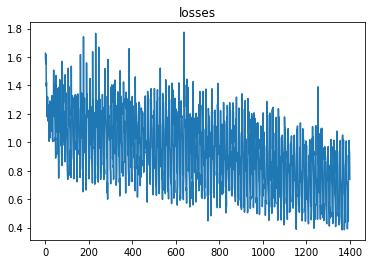

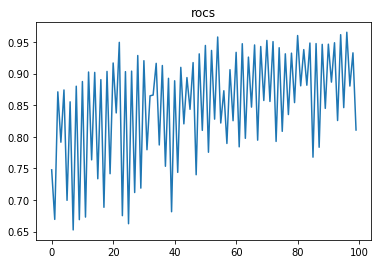

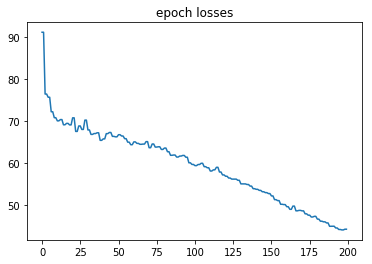

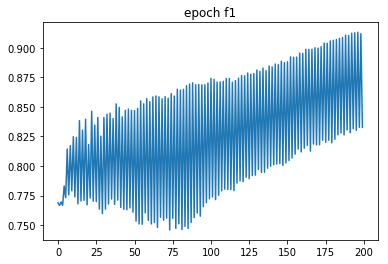

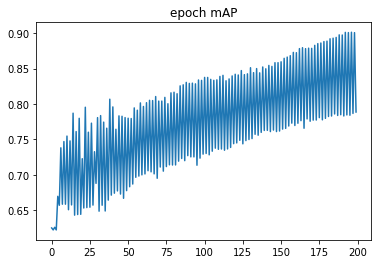

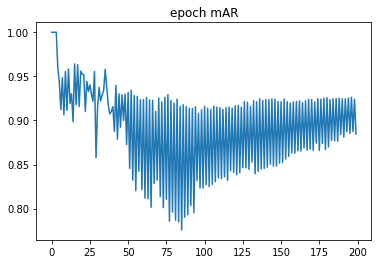

In [11]:
from matplotlib import pyplot as plt

plt.plot(ps_losses)
plt.title('losses')
plt.show()

plt.plot(ps_rocs)
plt.title('rocs')
plt.show()

plt.plot(ps_losses_ep)
plt.title('epoch losses')
plt.show()

plt.plot(ps_f1_ep)
plt.title('epoch f1')
plt.show()

plt.plot(ps_mAP_ep)
plt.title('epoch mAP')
plt.show()

plt.plot(ps_mAR_ep)
plt.title('epoch mAR')
plt.show()

In [ ]:
save_res = True

if save_res:
    # directory
    save_dir = 'files_MS_aug_bgrn1'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    model_path = 'jstars_bgrn1_ms_aug_ep{}_step{}_b{}.pt'.format(num_epochs, ps_step, bsize)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': ps_model.state_dict(),
            'epoch': ep,
            'step': ps_step,
        }, str(model_path))

    save(model_path)

    # save the AUCs
    auc_path = 'auc_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    auc_path = os.path.join(save_dir, auc_path)
    np.savetxt(auc_path, np.array(ps_rocs))

    #save the loss vectors
    ep_loss_path = 'losses_ep_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    ep_loss_path = os.path.join(save_dir, ep_loss_path)
    np.savetxt(ep_loss_path, np.array(ps_losses_ep))

    #save the total loss vector
    loss_path = 'loss_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    loss_path = os.path.join(save_dir, loss_path)
    np.savetxt(loss_path, np.array(ps_losses))
    
    # save the f1's
    f1_path = 'f1_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    f1_path = os.path.join(save_dir, f1_path)
    np.savetxt(loss_path, np.array(ps_f1_ep))
    
    # save the f1's
    f1_path = 'f1_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    f1_path = os.path.join(save_dir, f1_path)
    np.savetxt(f1_path, np.array(ps_f1_ep))
    
    # save the mAPs
    mAP_path = 'mAP_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    mAP_path = os.path.join(save_dir, mAP_path)
    np.savetxt(mAP_path, np.array(ps_mAP_ep))
    
    # save the mARs
    mAR_path = 'mAR_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    mAR_path = os.path.join(save_dir, mAR_path)
    np.savetxt(mAR_path, np.array(ps_mAR_ep))
  

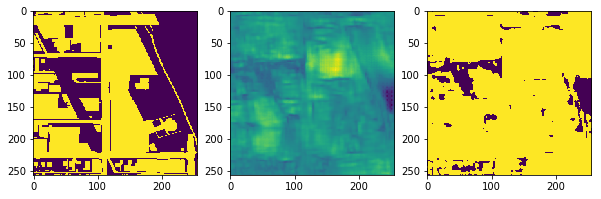

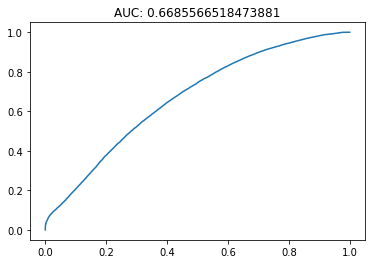

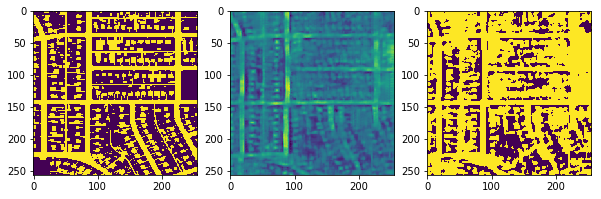

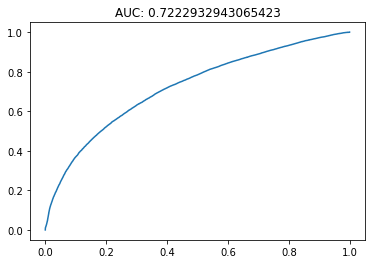

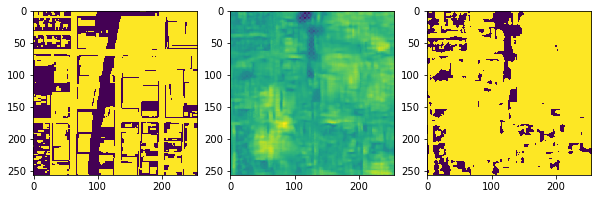

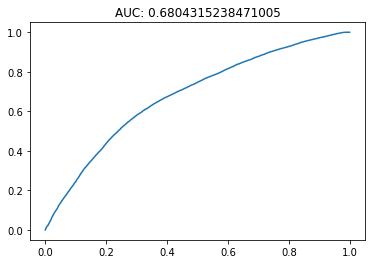

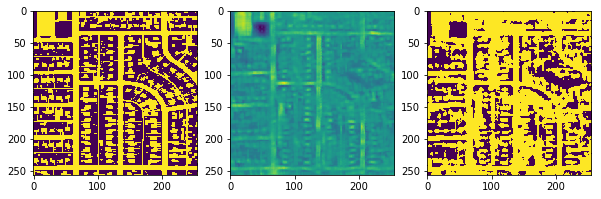

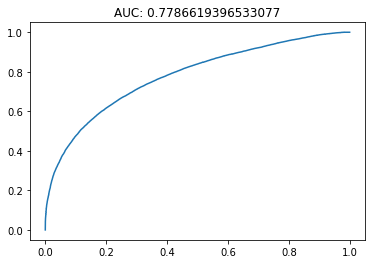

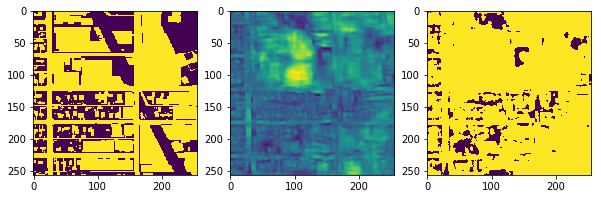

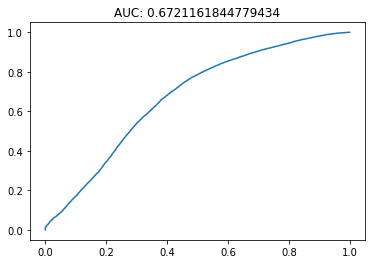

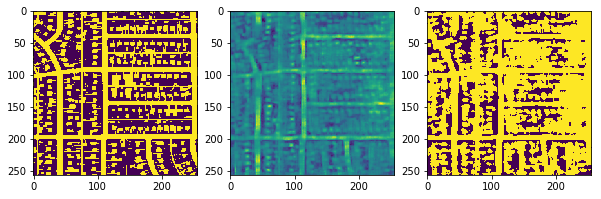

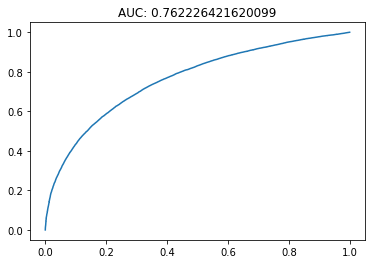

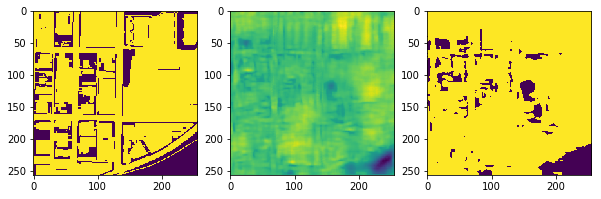

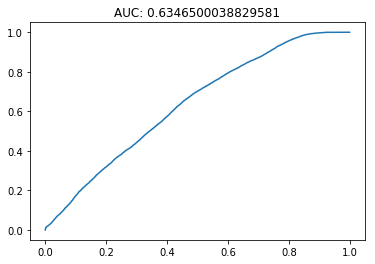

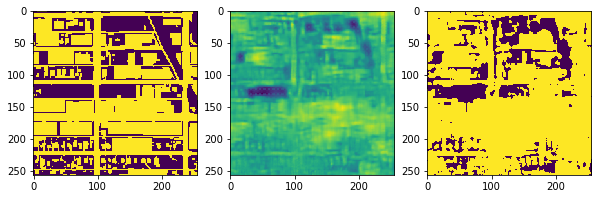

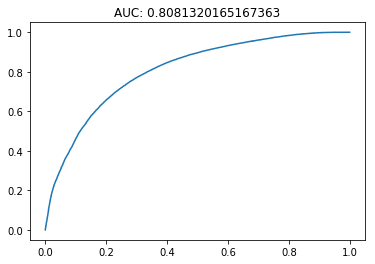

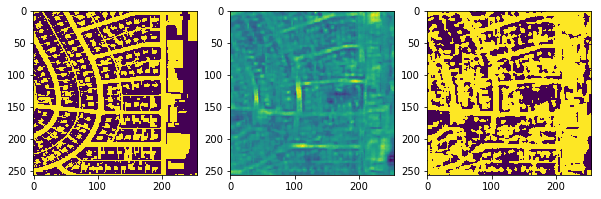

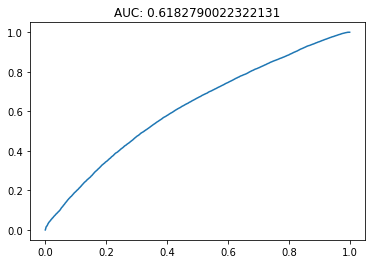

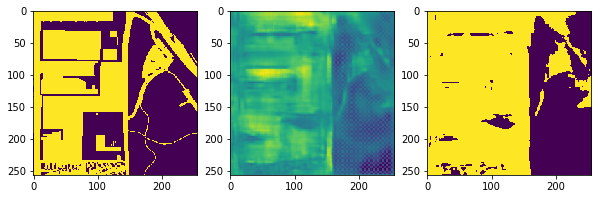

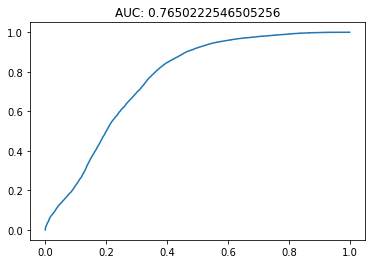

In [10]:
ps_model.eval()
for ind in range(0,10):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    test_im, test_target = ps_test_ds[ind]
    test_out = ps_model(variable(test_im.unsqueeze(0)))
    ax[0].imshow(test_target.numpy()[0])

    out = test_out.cpu().detach().numpy()[0][0]
    ax[1].imshow(out)

    ax[2].imshow(out>0)
    #ax[2].imshow(test_im.unsqueeze(0).cpu().detach().numpy()[0][0])
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target.numpy().flatten(), out.flatten())
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.title('AUC: {}'.format(roc_auc))